<a href="https://colab.research.google.com/github/jjeswinjacob/NLP_Lab_Solutions/blob/master/quoraFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


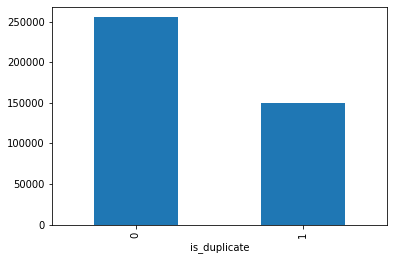

In [3]:
import pandas as pd
df = pd.read_csv('train.csv')
df.dropna(axis=0, inplace=True) # axis = 0 drops Rows with missing values and inplace changes values in the same dataframe
df.groupby("is_duplicate")['id'].count().plot.bar()
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True) # Drop specified columns; axis = 0 drops by row

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re

**Text Preprocessing**

In [5]:
def clean(text):
    # Clean the text
    text = re.sub("what's", "what is", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text, flags=re.IGNORECASE)
    text = re.sub("n't", " not ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)

    # Lemmatizing Text
    lemmatizer = WordNetLemmatizer() 
    words = nltk.word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(w) for w in words])
    
    return text
    
df['question1'] = df['question1'].apply(clean) # axis = 0 by default and to apply clean on every row in given dataframe
df['question2'] = df['question2'].apply(clean)

Regularization Parameters Legend:

* Gamma - Tree Complexity Parameter - Minimum loss reduction required to make a further partition on a leaf node of the tree. If Gain - Gamma = +ve, we keep node, else discard. So, we don't prune as long as we have a positive gain.

* Alpha - L1 (Lasso) regularization on leaf weights - Larger values of Alpha helps us do away with useless features.

* Lambda - L2 (Ridge) regularization on leaf weights - Introduces Bias to reduce Variance - Reduces Similarity score, so with gamma we can easily prune. Prunes and combines observations with other observations. Lambda also results in smaller output values.

* scale_pos_weight set to ratio of negative class entities to positive class entities

**Model 1: BOW -> XGBoost**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Countvectorizer lowercases all words by default and removes punctuation
count_vect = CountVectorizer(analyzer='word')
# The fit method learns the vocabulary of all tokens in the documents
count_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = count_vect.transform(df['question1'].values)
trainq2_trans = count_vect.transform(df['question2'].values)

import scipy
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = df['is_duplicate'].values

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

!pip install xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.679638
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.70193
[2]	validation_0-aucpr:0.71836
[3]	validation_0-aucpr:0.729554
[4]	validation_0-aucpr:0.735555
[5]	validation_0-aucpr:0.74137
[6]	validation_0-aucpr:0.745527
[7]	validation_0-aucpr:0.750151
[8]	validation_0-aucpr:0.754121
[9]	validation_0-aucpr:0.758675
[10]	validation_0-aucpr:0.762979
[11]	validation_0-aucpr:0.767085
[12]	validation_0-aucpr:0.770508
[13]	validation_0-aucpr:0.772949
[14]	validation_0-aucpr:0.776118
[15]	validation_0-aucpr:0.778538
[16]	validation_0-aucpr:0.780527
[17]	validation_0-aucpr:0.782577
[18]	validation_0-aucpr:0.784386
[19]	validation_0-aucpr:0.786479
[20]	validation_0-aucpr:0.787911
[21]	validation_0-aucpr:0.788909
[22]	validation_0-aucpr:0.790754
[23]	validation_0-aucpr:0.792262
[24]	validation_0-aucpr:0.793442
[25]	validation_0-aucpr:0.794316
[26]	validation_0-aucpr:0.795235
[27]	validation_0-aucpr:0.79598
[28]	validation_0-aucpr:

Legend:
* Precision is out of all predictions of one class, how many are right. TP/ (TP + FP) eg. Out of all duplicate prediction, how many are actually duplicate

* Recall(Senstivity) is out of all entities of one class, how many are correctly predicted. TP/ (TP + FN) eg. Out of all duplicate questions in dataset, how many are predicted correctly

* f1-score = 2(Precision * Recall)/ (Precision + Recall) - Harmonic Mean of Precision and Recall
 f1-score = TP/ (TP + (FP + FN)/ 2)

* Macro average is unweighted average of probabilities in both class.

* Support is the number of actual occurrences of the class in the specified dataset. 

* Weighted average gives the support-weighted mean per label.

**Model 2: TFIDF + XGBoost**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word')
tfidf_vect.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect.transform(df['question1'].values)
trainq2_trans = tfidf_vect.transform(df['question2'].values)
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.678644
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.702687
[2]	validation_0-aucpr:0.719437
[3]	validation_0-aucpr:0.731345
[4]	validation_0-aucpr:0.74073
[5]	validation_0-aucpr:0.747252
[6]	validation_0-aucpr:0.752934
[7]	validation_0-aucpr:0.758068
[8]	validation_0-aucpr:0.762637
[9]	validation_0-aucpr:0.767321
[10]	validation_0-aucpr:0.771125
[11]	validation_0-aucpr:0.774424
[12]	validation_0-aucpr:0.777103
[13]	validation_0-aucpr:0.780107
[14]	validation_0-aucpr:0.78265
[15]	validation_0-aucpr:0.785446
[16]	validation_0-aucpr:0.788364
[17]	validation_0-aucpr:0.790417
[18]	validation_0-aucpr:0.792057
[19]	validation_0-aucpr:0.793502
[20]	validation_0-aucpr:0.795442
[21]	validation_0-aucpr:0.797063
[22]	validation_0-aucpr:0.798316
[23]	validation_0-aucpr:0.799152
[24]	validation_0-aucpr:0.800078
[25]	validation_0-aucpr:0.80103
[26]	validation_0-aucpr:0.802783
[27]	validation_0-aucpr:0.803474
[28]	validation_0-aucpr

**Model 3: Character Level TFIDF -> XGBoost**

In [ ]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,4))
tfidf_vect_ngram_chars.fit(pd.concat((df['question1'],df['question2'])).unique())

trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.656739
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.71425
[2]	validation_0-aucpr:0.739088
[3]	validation_0-aucpr:0.754692
[4]	validation_0-aucpr:0.766862
[5]	validation_0-aucpr:0.776422
[6]	validation_0-aucpr:0.784029
[7]	validation_0-aucpr:0.790575
[8]	validation_0-aucpr:0.79483
[9]	validation_0-aucpr:0.79899
[10]	validation_0-aucpr:0.803742
[11]	validation_0-aucpr:0.807545
[12]	validation_0-aucpr:0.810842
[13]	validation_0-aucpr:0.813623
[14]	validation_0-aucpr:0.816389
[15]	validation_0-aucpr:0.81845
[16]	validation_0-aucpr:0.821171
[17]	validation_0-aucpr:0.823928
[18]	validation_0-aucpr:0.826198
[19]	validation_0-aucpr:0.828533
[20]	validation_0-aucpr:0.830801
[21]	validation_0-aucpr:0.832707
[22]	validation_0-aucpr:0.834134
[23]	validation_0-aucpr:0.835662
[24]	validation_0-aucpr:0.837661
[25]	validation_0-aucpr:0.838971
[26]	validation_0-aucpr:0.840289
[27]	validation_0-aucpr:0.841598
[28]	validation_0-aucpr:

**Conclusion**: Three different models were used to classify the pairs of questions as duplicate or not duplicate. The word level BOW model gave an accuracy of 80%, the word level TFIDF gave an accuracy of 81% - a slightly better improvement owing to the removal of useless words. The character level TFIDF consisting of bigrams, trigrams, and 4-grams gave the best accuracy of 84%. This is owing to the reason that there are various different words with the same meaning, which can't be captured by word level BOW or word level TFIDF eg. lover and loving. Thus, where word level BOW and TFIDF lose out on valuable information, character level n-gram TFIDF can capture.

**Future Enhancements**: 
* Cosine distance, and the Word Mover's Distance can be used to capture more information from the questions to help classify with more accuracy. 

* Combining more than one model.

* Further hyperparameter tuning using gridSearch can lead to further improvement of accuracy.

* Deep learning models could be experimented with

Sources/ References:
1. Finding Similar Quora Questions with BOW, TFIDF and Xgboost.
Source: https://towardsdatascience.com/finding-similar-quora-questions-with-bow-tfidf-andrandom-forest-c54ad88d1370
2. XGBoost in Python from Start to Finish.
Source:https://www.youtube.com/watch?v=GrJP9FLV3FE&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=63
3. Machine learning playlist by Josh Starmer.
Source: https://www.youtube.com/playlist?list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF
4. Feature Engineering for NLP in Python.
Source: https://learn.datacamp.com/courses/feature-engineering-for-nlp-in-python
5. Extreme Gradient Boosting with XGBoost.
Source: https://learn.datacamp.com/courses/extreme-gradient-boosting-with-xgboost
6. XgBoost Documentation.
Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html
7. Count Vectorizer Documentation.
Source:https://scikitlearn.org/stable/modules/generated/sklearn.feature_extraction.text.Count
Vectorizer.html
8. TFIDF Vectorizer Documentation:
Source:https://scikitlearn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
9. Why is XGBoost among most used machine learning method on Kaggle?
Source: https://www.quora.com/Why-is-XGBoost-among-most-used-machine-learning-methodon-Kaggle
10. Quora Question Pairs dataset.
Source: https://www.kaggle.com/c/quora-question-pairs/data

**Model 4: POS + XGBoost**

In [7]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
def POS(text):
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    pos = ' '.join([t[1] for t in tags])
    return pos
    
df['POS1'] = df['question1'].apply(POS) # axis = 0 by default and to apply POS on every row in given dataframe
df['POS2'] = df['question2'].apply(POS)

a = 0 
for i in range(a,a+10):
    print(df.POS1[i])
    print(df.POS2[i])
    print()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
WP VBZ DT NN IN NN RB TO VB IN NN NN IN NN .
WP VBZ DT NN IN NN RB TO VB IN NN NN .

WP VBZ DT NN IN NNP ( NNP ) NNP .
WP MD VB IN DT JJ NN VBD DT NNP ( NNP ) NN RB .

WRB MD PRP VB DT NN IN PRP$ JJ NN IN VBG DT NNP .
WRB MD NNP NN VB VBN IN VBG IN NNP .

WRB VBP PRP RB RB RB . WRB MD PRP VB PRP .
IN DT NN WRB NNP NN VBD CD ( CD ) NNP NNP NNP VBZ VBN IN CD .

WDT CD NN IN NN NN NN , NN , NN CC NN NN IN .
JJ NN MD VB IN NN NN .

NN : PRP VBP DT NNP NNP NNP NN CC NN NN : WP VBZ DT VBP IN PRP .
PRP VBP DT JJ NNP ( NNP , NNP CC NN IN NNP ) WP VBZ DT VB IN PRP .

MD PRP VB IN .
WP VBZ JJ JJ CC RB IN NN CC NN NNS .

WRB MD PRP VB DT JJ NN .
WP MD PRP VB TO VB DT JJ NN .

WRB VBP PRP VB JJ RB IN NNS

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# Countvectorizer lowercases all words by default and removes punctuation
count_vect = CountVectorizer(analyzer='word')
# The fit method learns the vocabulary of all tokens in the documents
count_vect.fit(pd.concat((df['POS1'],df['POS2'])).unique())

trainq1_trans = count_vect.transform(df['POS1'].values)
trainq2_trans = count_vect.transform(df['POS2'].values)

import scipy
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = df['is_duplicate'].values

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

!pip install xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.600182
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.632764
[2]	validation_0-aucpr:0.650587
[3]	validation_0-aucpr:0.660744
[4]	validation_0-aucpr:0.667038
[5]	validation_0-aucpr:0.67228
[6]	validation_0-aucpr:0.678098
[7]	validation_0-aucpr:0.681992
[8]	validation_0-aucpr:0.68531
[9]	validation_0-aucpr:0.688047
[10]	validation_0-aucpr:0.692461
[11]	validation_0-aucpr:0.695726
[12]	validation_0-aucpr:0.698929
[13]	validation_0-aucpr:0.701506
[14]	validation_0-aucpr:0.704328
[15]	validation_0-aucpr:0.706722
[16]	validation_0-aucpr:0.709388
[17]	validation_0-aucpr:0.711776
[18]	validation_0-aucpr:0.71392
[19]	validation_0-aucpr:0.715749
[20]	validation_0-aucpr:0.718441
[21]	validation_0-aucpr:0.720477
[22]	validation_0-aucpr:0.721989
[23]	validation_0-aucpr:0.723459
[24]	validation_0-aucpr:0.724459
[25]	validation_0-aucpr:0.725566
[26]	validation_0-aucpr:0.726842
[27]	validation_0-aucpr:0.728255
[28]	validation_0-aucpr

**Model 5: POS + NER + XGBoost**

In [12]:
import spacy
m = spacy.load('en_core_web_sm')

def NER(text):
    tagged = m(text)
    ner = ' '.join([ent.label_ for ent in tagged.ents])
    return ner
    
df['NER1'] = df['question1'].apply(NER) # axis = 0 by default and to apply NER on every row in given dataframe
df['NER2'] = df['question2'].apply(NER)

a = 0 
for i in range(a,a+10):
    print(df.NER1[i])
    print(df.NER2[i])
    print()

GPE


GPE
NORP

ORG
ORG


CARDINAL

CARDINAL


PERSON
ORG ORG PERSON GPE










ORG PERSON
ORG



In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# Countvectorizer lowercases all words by default and removes punctuation
count_vect = CountVectorizer(analyzer='word')
# The fit method learns the vocabulary of all tokens in the documents
count_vect.fit(pd.concat((df['POS1'],df['POS2'],df['NER1'],df['NER2'])).unique())

trainq1_trans_NER = count_vect.transform(df['NER1'].values)
trainq2_trans_NER = count_vect.transform(df['NER2'].values)
trainq1_trans_POS = count_vect.transform(df['POS1'].values)
trainq2_trans_POS = count_vect.transform(df['POS2'].values)

import scipy
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans, trainq1_trans_POS, trainq2_trans_POS))
y = df['is_duplicate'].values

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

!pip install xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.614024
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.650278
[2]	validation_0-aucpr:0.665026
[3]	validation_0-aucpr:0.673595
[4]	validation_0-aucpr:0.680491
[5]	validation_0-aucpr:0.684417
[6]	validation_0-aucpr:0.689242
[7]	validation_0-aucpr:0.693111
[8]	validation_0-aucpr:0.698108
[9]	validation_0-aucpr:0.701985
[10]	validation_0-aucpr:0.704777
[11]	validation_0-aucpr:0.709226
[12]	validation_0-aucpr:0.712171
[13]	validation_0-aucpr:0.715733
[14]	validation_0-aucpr:0.718554
[15]	validation_0-aucpr:0.721425
[16]	validation_0-aucpr:0.724042
[17]	validation_0-aucpr:0.726012
[18]	validation_0-aucpr:0.728188
[19]	validation_0-aucpr:0.73058
[20]	validation_0-aucpr:0.732687
[21]	validation_0-aucpr:0.73457
[22]	validation_0-aucpr:0.736848
[23]	validation_0-aucpr:0.738719
[24]	validation_0-aucpr:0.740269
[25]	validation_0-aucpr:0.741965
[26]	validation_0-aucpr:0.743144
[27]	validation_0-aucpr:0.744235
[28]	validation_0-aucp

**Model 6: Cosine Distance + XGBoost**

In [21]:
import re
import math
from collections import Counter

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def COSINE(q1, q2):
    vector1 = text_to_vector(q1)
    vector2 = text_to_vector(q2)
    cosine_result = get_cosine(vector1, vector2)
    return cosine_result

df['cosine'] = df.apply(lambda x: COSINE(x['question1'], x['question2']), axis=1)
a = 0 
for i in range(a,a+10):
    print(df.cosine[i])
    print()

0.9449111825230682

0.5368754921931592

0.253546276418555

0.0

0.4193139346887673

0.5564148840746571

0.0

0.5039526306789696

0.8017837257372731

0.4444444444444444



In [26]:
X = df.loc[:, df.columns == 'cosine']
y = df['is_duplicate'].values

from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.25, random_state = 18, stratify = y)

!pip install xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=60, learning_rate=0.15, n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=4, reg_lambda=0, scale_pos_weight = 1.7)
xgb_model = xgb_model.fit(X_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(X_valid, y_valid)]) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import classification_report
print(classification_report(y_valid, xgb_prediction))

[0]	validation_0-aucpr:0.571106
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.572539
[2]	validation_0-aucpr:0.572827
[3]	validation_0-aucpr:0.57425
[4]	validation_0-aucpr:0.573966
[5]	validation_0-aucpr:0.574852
[6]	validation_0-aucpr:0.5756
[7]	validation_0-aucpr:0.575709
[8]	validation_0-aucpr:0.575836
[9]	validation_0-aucpr:0.576341
[10]	validation_0-aucpr:0.576407
[11]	validation_0-aucpr:0.576792
[12]	validation_0-aucpr:0.577149
[13]	validation_0-aucpr:0.577229
[14]	validation_0-aucpr:0.577384
[15]	validation_0-aucpr:0.577299
[16]	validation_0-aucpr:0.577496
[17]	validation_0-aucpr:0.577607
[18]	validation_0-aucpr:0.577764
[19]	validation_0-aucpr:0.577698
[20]	validation_0-aucpr:0.577618
[21]	validation_0-aucpr:0.577773
[22]	validation_0-aucpr:0.577735
[23]	validation_0-aucpr:0.577907
[24]	validation_0-aucpr:0.577834
[25]	validation_0-aucpr:0.577991
[26]	validation_0-aucpr:0.577942
[27]	validation_0-aucpr:0.577957
[28]	validation_0-aucpr